# Tutorial 30: Protein Deep Learning 
by David Ricardo Figueroa Blanco

In this tutorial we will  compare  protein sequences featurization  such as one hot encoders and aminoacids composition. We will use some tools of DeepChem and additional packages to create a model to predict melting temperature of proteins ( a good measurement of protein stability )    
   
The melting temperature (MT) of a protein is a measurement of protein stability. This measure could vary from a big variety of experimental conditions, however, curated databases cand be found in literature https://aip.scitation.org/doi/10.1063/1.4947493. In this paper we can find a lot of thermodynamic information of proteins and therefore a big resource for the study of protein stability. Other information related with protein stability could be the change in Gibbs Free Energy $ \Delta \Delta G°$ due to a mutation. 

The study of protein stability is important in areas such as protein engineering and biocatalysis because catalytic efficiency could be directly related to the tertiary structure of the protein in study.

# Setup
To run DeepChem within Colab, you'll need to run the following installation commands. This will take about 5 minutes to run to completion and install your environment. You can of course run this tutorial locally if you prefer. In that case, don't run these cells since they will download and install Anaconda on your local machine.

In [ ]:
!curl -Lo conda_installer.py https://raw.githubusercontent.com/deepchem/deepchem/master/scripts/colab_install.py
import conda_installer
conda_installer.install()
!/root/miniconda/bin/conda info -e

In [ ]:
!pip install --pre deepchem
!pip install propy3 

# Data extraction

In this cell, we download the dataset published in the paper https://aip.scitation.org/doi/10.1063/1.4947493 from the DeepChem dataset repository

In [1]:
import deepchem as dc 
import os 
from deepchem.utils import download_url
data_dir = dc.utils.get_data_dir()
download_url("https://deepchemdata.s3-us-west-1.amazonaws.com/datasets/pucci-proteins-appendixtable1.csv",dest_dir=data_dir)
print('Dataset Dowloaded at {}'.format(data_dir))
dataset_file = os.path.join(data_dir, "pucci-proteins-appendixtable1.csv")

Dataset Dowloaded at /tmp


A closer look of the dataset: Contains the PDBid and the respective mutation and change in thermodynamical properties in each studied protein

In [2]:
import pandas as pd 
data = pd.read_csv(dataset_file)
data

,Unnamed: 0,N,PDBid,Chain,RESN,RESwt,RESmut,ΔTmexp,Tmexp [wt],ΔΔHmexp,...,ΔΔGexp(T),T,Nres,R (Å),Protein,Organism,Ref.,pH,Exp.Tech.,
0,NaN,1,1aky,A,8,VAL,ILE,-1.5,47.6,70,...,5.0,25,220,1.63,ADK,Yeast,[1],[7.5],FL,NaN
1,NaN,2,1aky,A,48,GLN,GLU,-1.3,47.6,60,...,4.0,25,220,1.63,ADK,Yeast,[1],[7.7],FL,NaN
2,NaN,3,1aky,A,77,THR,HIS,-1.1,47.6,130,...,9.0,25,220,1.63,ADK,Yeast,[1],[7.5],FL,NaN
3,NaN,4,1aky,A,110,THR,HIS,-4.8,47.6,165,...,11.0,25,220,1.63,ADK,Yeast,[1],[7.6],FL,NaN
4,NaN,5,1aky,A,169,ASN,ASP,-0.6,47.6,140,...,9.0,25,220,1.63,ADK,Yeast,[1],[7.5],FL,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1621,NaN,1622,5pti_m52l,A,15,LYS,SER,-1.3,91.7,-5,...,1.2,25,58,1.00,PTI M52L,Bovine,[232],[3.0],DSC,NaN
1622,NaN,1623,5pti_m52l,A,15,LYS,THR,-1.1,91.7,-9,...,-3.6,25,58,1.00,PTI M52L,Bovine,[232],[3.0],DSC,NaN
1623,NaN,1624,5pti_m52l,A,15,LYS,VAL,-6.3,91.7,4,...,4.7,25,58,1.00,PTI M52L,Bovine,[232],[3.0],DSC,NaN
1624,NaN,1625,5pti_m52l,A,15,LYS,TRP,-7.5,91.7,17,...,8.5,25,58,1.00,PTI M52L,Bovine,[232],[2.5],DSC,NaN


Here we extract a small DataFrame that only contains a unique PDBid code and its respective melting temperature

In [3]:
WT_Tm = data[['PDBid','Tmexp [wt]']]
WT_Tm.set_index('PDBid',inplace=True)

In [4]:
WT_Tm

,Tmexp [wt]
PDBid,
1aky,47.6
1aky,47.6
1aky,47.6
1aky,47.6
1aky,47.6
...,...
5pti_m52l,91.7
5pti_m52l,91.7
5pti_m52l,91.7


Here we create a dictionary that contains as keys, the pdbid of each protein and  as values, the wild type melting temperature

In [5]:
dict_WT_TM = {}
for k,v in WT_Tm.itertuples():
    if(k not in dict_WT_TM):
        dict_WT_TM[k]=float(v)

Here we extract proteins with mutations reported only in chain A 

In [6]:
pdbs = data[data['PDBid'].str.len()<5]
pdbs = pdbs[pdbs['Chain'] == "A"]

In [7]:
pdbs[['RESN','RESwt','RESmut']]

,RESN,RESwt,RESmut
0,8,VAL,ILE
1,48,GLN,GLU
2,77,THR,HIS
3,110,THR,HIS
4,169,ASN,ASP
...,...,...,...
1604,36,GLY,ALA
1605,36,GLY,SER
1606,37,GLY,ALA
1607,39,ARG,ALA


This cell extracts the total number of mutations and changes in MT. In addition, we use a dicctionary to convert the residue mutation in a one letter code.

In [8]:
alls=[]
for resnum,wt in pdbs[['RESN','RESwt','RESmut','PDBid','ΔTmexp']].iteritems():
    alls.append(wt.values)
d = {'CYS': 'C', 'ASP': 'D', 'SER': 'S', 'GLN': 'Q', 'LYS': 'K',
     'ILE': 'I', 'PRO': 'P', 'THR': 'T', 'PHE': 'F', 'ASN': 'N', 
     'GLY': 'G', 'HIS': 'H', 'LEU': 'L', 'ARG': 'R', 'TRP': 'W', 
     'ALA': 'A', 'VAL':'V', 'GLU': 'E', 'TYR': 'Y', 'MET': 'M'}
resnum=alls[0]
wt=[d[x.strip()] for x in alls[1]] # extract the Wildtype aminoacid with one letter code 
mut=[d[x.strip()] for x in alls[2]] # extract the Mutation aminoacid with one letter code 
codes=alls[3] # PDB code 
tms=alls[4] # Melting temperature

In [9]:
print("pdbid {}, WT-AA {}, Resnum {}, MUT-AA {},DeltaTm {}".format(codes[0],wt[0],resnum[0],mut[0],tms[0]))


pdbid 1aky, WT-AA V, Resnum 8, MUT-AA I,DeltaTm -1.5


# PDB Download 

Here we download all the pdbs by PDBID using the pdbfixer tool

In [10]:
from pdbfixer import PDBFixer
from simtk.openmm.app import PDBFile

In [11]:
!mkdir PDBs

mkdir: cannot create directory ‘PDBs’: File exists


Using the fixer from pdbfixer we download each protein from its PDB code and fix some common problems present in the Protein Data Bank Files. This process will take around 15 minutes and 100 Mb. 
The use of the PDBFixer can be found in https://htmlpreview.github.io/?https://github.com/openmm/pdbfixer/blob/master/Manual.html . In our case, we download the pdb file from the pdb code and perform some curation such as find Nonstandar or missing residues, fix missing atoms 

In [27]:
import os 
import time
t0 = time.time()

downloaded = os.listdir("PDBs")
PDBs_ids= set(pdbs['PDBid'])
pdb_list = []
print("Start Download ")
for pdbid in PDBs_ids:
    name=pdbid+".pdb"
    if(name in downloaded):
        continue
    try:
        fixer = PDBFixer(pdbid=pdbid)
        fixer.findMissingResidues()
        fixer.findNonstandardResidues()
        fixer.replaceNonstandardResidues()
        fixer.removeHeterogens(True)
        fixer.findMissingAtoms()
        fixer.addMissingAtoms()
        PDBFile.writeFile(fixer.topology, fixer.positions, open('./PDBs/%s.pdb' % (pdbid), 'w'),keepIds=True)
    except:
        print("Problem with {}".format(pdbid))
print("Total Time {}".format(time.time()-t0))

Start Download 
Total Time 1155.9134647846222


The following function help us to mutate a sequence denoted as  A###B where A is the wildtype aminoacid, ### the position and, B the new aminoacid 

In [34]:
import re
def MutateSeq(seq,Mutant):
    '''
    Mutate a sequence based on a string (Mutant) that has the notation : 
    A###B where A is the wildtype aminoacid ### the position and B the mutation
    '''
    aalist = re.findall('([A-Z])([0-9]+)([A-Z])', Mutant)
    
    #(len(aalist)==1):
    newseq=seq
    listseq=list(newseq)
    for aas in aalist:
        wildAA = aas[0]
        pos = int(aas[1]) -1
        if(pos >= len(listseq)):
            print("Mutation not in the range of the protein")
            return None
        MutAA = aas[-1]
        
        if(listseq[pos]==wildAA):
            
            listseq[pos]=MutAA
            
        else:
            #print("WildType AA does not match")
            return None
    return("".join(listseq))

The following function help us to identify a sequence of aminoacids base on PDB structures

In [35]:
from Bio.PDB.PDBParser import PDBParser
from Bio.PDB.Polypeptide import PPBuilder
ppb=PPBuilder()
def GetSeqFromPDB(pdbid):
    structure = PDBParser().get_structure(pdbid.split(".")[0], 'PDBs/{}'.format(pdbid))
    seqs=[]
    return ppb.build_peptides(structure)
    

Some examples of the described functions : 
GetSeqFromPDB. Take one pdb that we previously downloaded and extract the sequence in one letter code 

In [36]:
import warnings; warnings.simplefilter('ignore')
test="1ezm"
print(test)
seq = GetSeqFromPDB("{}.pdb".format(test))[0].get_sequence()
print("Original Sequence")
print(seq)


1ezm
Original Sequence
AEAGGPGGNQKIGKYTYGSDYGPLIVNDRCEMDDGNVITVDMNSSTDDSKTTPFRFACPTNTYKQVNGAYSPLNDAHFFGGVVFKLYRDWFGTSPLTHKLYMKVHYGRSVENAYWDGTAMLFGDGATMFYPLVSLDVAAHEVSHGFTEQNSGLIYRGQSGGMNEAFSDMAGEAAEFYMRGKNDFLIGYDIKKGSGALRYMDQPSRDGRSIDNASQYYNGIDVHHSSGVYNRAFYLLANSPGWDTRKAFEVFVDANRYYWTATSNYNSGACGVIRSAQNRNYSAADVTRAFSTVGVTCPSAL


Information about the mutation 

In [37]:
informSeq=GetSeqFromPDB(test+".pdb")[0].__repr__()
print("Seq information",informSeq)
start = re.findall('[0-9]+',informSeq)[0]
print("Reported Mutation {}{}{}".format("R",179,"A"))
numf =179 - int(start) + 1  # fix some cases of negative aminoacid numbers

Seq information <Polypeptide start=1 end=301>
Reported Mutation R179A


Mutation in the sequence. 

In [38]:
mutfinal = "R{}A".format(numf)
print("Real Mutation = ",mutfinal)
mutseq = MutateSeq(seq,mutfinal)
print(mutseq)

Real Mutation =  R179A
AEAGGPGGNQKIGKYTYGSDYGPLIVNDRCEMDDGNVITVDMNSSTDDSKTTPFRFACPTNTYKQVNGAYSPLNDAHFFGGVVFKLYRDWFGTSPLTHKLYMKVHYGRSVENAYWDGTAMLFGDGATMFYPLVSLDVAAHEVSHGFTEQNSGLIYRGQSGGMNEAFSDMAGEAAEFYMAGKNDFLIGYDIKKGSGALRYMDQPSRDGRSIDNASQYYNGIDVHHSSGVYNRAFYLLANSPGWDTRKAFEVFVDANRYYWTATSNYNSGACGVIRSAQNRNYSAADVTRAFSTVGVTCPSAL


In this for loop we extract the sequences of all proteins in the dataset. In addition we created the mutated sequences and append the change in MT. In some cases, gaps in pdbs will cause that mutateSeq function fails, therefore this entries will be avoided. This is an important step in the whole process because creates a final tabulated data that contains the sequence and the Melting temperature ( our label)

In [39]:
information = {}
count = 1
failures=[]
for code,tm,numr,wt_val,mut_val in zip(codes,tms,resnum,wt,mut):
    count += 1
    seq = GetSeqFromPDB("{}.pdb".format(code))[0].get_sequence()
    mutfinal="WT"
    if("{}-{}".format(code,mutfinal) not in information):
        informSeq=GetSeqFromPDB(code+".pdb")[0].__repr__()
        start = re.findall('[-0-9]+',informSeq)[0]
    if(int(start)<0):
        numf =numr - int(start) # if start is negative 0 is not used as resnumber
    else:
        numf =numr - int(start) + 1 
    mutfinal = "{}{}{}".format(wt_val,numf,mut_val)
    mutseq = MutateSeq(seq,mutfinal)
    if(mutseq==None):
        failures.append((code,mutfinal))
        continue
    information["{}-{}".format(code,mutfinal)]=[mutseq,dict_WT_TM[code]-float(tm)]


# Deep Learning and Machine Learning Models using proteins sequences 

In [40]:
import deepchem as dc

Here we extract two list, sequences (data) and  melting temperature (label)

In [41]:
seq_list=[]
deltaTm=[]
for i in information.values():
    seq_list.append(i[0])
    deltaTm.append(i[1])

In [42]:
max_seq= 0 
for i in seq_list:
    if(len(i)>max_seq):
        max_seq=len(i)

Here we use a OneHotFeaturizer in order to convert protein sequences in numeric arrays

In [43]:
codes = ['A', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'K', 'L',
         'M', 'N', 'P', 'Q', 'R', 'S', 'T', 'V', 'W', 'Y']
OneHotFeaturizer = dc.feat.OneHotFeaturizer(codes,max_length=max_seq)
features = OneHotFeaturizer.featurize(seq_list)

In [44]:
dc_dataset = dc.data.NumpyDataset(X=features,y=deltaTm)

Here we create a spliiter to perform a tran_test split of the dataset

In [45]:
from deepchem import splits
splitter = splits.RandomSplitter()
train, test  = splitter.train_test_split(dc_dataset,seed=42)

Here we create a neuronal network using tensorflow-keras and using a loss function of "MAE" to evaluate the regression result.

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 628, 32)           704       
_________________________________________________________________
dropout (Dropout)            (None, 628, 32)           0         
_________________________________________________________________
dense_1 (Dense)              (None, 628, 64)           2112      
_________________________________________________________________
dropout_1 (Dropout)          (None, 628, 64)           0         
_________________________________________________________________
dense_2 (Dense)              (None, 628, 128)          8320      
_________________________________________________________________
dropout_2 (Dropout)          (None, 628, 128)          0         
_________________________________________________________________
dense_3 (Dense)              (None, 628, 1)            1

<AxesSubplot:>

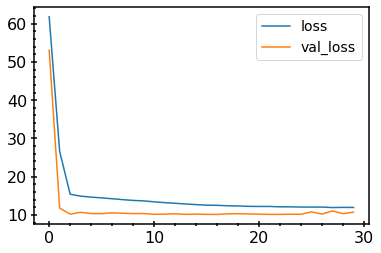

In [46]:
from tensorflow import keras
from tensorflow.keras import layers
model = keras.Sequential([
    layers.Dense(units=32, activation='relu', input_shape=dc_dataset.X.shape[1:]),
    layers.Dropout(0.4),
    layers.Dense(units=64, activation='relu'), 
    layers.Dropout(0.5),
    layers.Dense(units=128, activation='relu'), 
    layers.Dropout(0.2),
    layers.Dense(units=1),
])
model.compile(loss='mae', optimizer='adam')

print(model.summary())

history = model.fit(
    train.X, train.y,
    validation_data=(test.X,test.y),
    batch_size=24,
    epochs=30,
)

## perform a plot of loss vs epochs 
import matplotlib.pyplot as plt
history_df = pd.DataFrame(history.history)
history_df[['loss', 'val_loss']].plot()

# Use DeepChem Keras Model

In [52]:
from tensorflow import keras
from tensorflow.keras import layers
model = keras.Sequential([
    layers.Dense(units=32, activation='relu', input_shape=dc_dataset.X.shape[1:]),
    layers.Dropout(0.2),
    layers.Dense(units=32, activation='relu'), 
    layers.Dropout(0.2),
    layers.Dense(units=32, activation='relu'), 
    layers.Dropout(0.2),
    layers.Dense(units=1),
])

dcmodel = dc.models.KerasModel(model,loss=dc.metrics.mae_score)

In [53]:
dcmodel.fit(dc_dataset)

TypeError: in user code:

    /home/david/anaconda3/envs/deepchem-night/lib/python3.8/site-packages/deepchem/models/keras_model.py:469 apply_gradient_for_batch  *
        batch_loss = loss(outputs, labels, weights)

    TypeError: tf__mae_score() takes 2 positional arguments but 3 were given


# Examples of Classic ML models 

Finally, we will compare others descriptros such as AAcomposition and Composition,transition and distribution of AA (https://www.pnas.org/content/92/19/8700)  

In [54]:
from propy import PyPro

In the following cell, we are creating and pyPro Object based on the protein sequence. Pypro allows us the calculation of amino acid composition vectors    
Here we create a list with the aminoacido composition vector for each sequence used in the previous model.


In [55]:
import numpy as np 
aaComplist = []
CTDList =[]
for seq in seq_list:
    Obj = PyPro.GetProDes(seq)
    aaComplist.append(np.array(list(Obj.GetAAComp().values())))
    CTDList.append(np.array(list(Obj.GetCTD().values())))

In [57]:
dc_dataset_aacomp = dc.data.NumpyDataset(X=aaComplist,y=deltaTm)
dc_dataset_ctd = dc.data.NumpyDataset(X=CTDList,y=deltaTm)

# Evaluation of classical machine learning models 

In the following cell we create a randomForest Regressor and the deepchem SklearnModel. As it was used in the DL models, here we use "MAE" score to evaluate the results of the regression 

In [58]:
from deepchem import splits
splitter = splits.RandomSplitter()
train, test  = splitter.train_test_split(dc_dataset_aacomp,seed=42)
from sklearn.ensemble import RandomForestRegressor
from deepchem.utils.evaluate import Evaluator
import pandas as pd
print("RandomForestRegressor")
seed = 42 # Set a random seed to get stable results
sklearn_model = RandomForestRegressor(n_estimators=100, max_features='sqrt')
sklearn_model.random_state = seed
model = dc.models.SklearnModel(sklearn_model)
model.fit(train)
metric = dc.metrics.Metric(dc.metrics.mae_score)
train_score = model.evaluate(train, [metric])
test_score = model.evaluate(test, [metric])
print("Train score is : {}".format(train_score))
print("Test score is : {}".format(test_score))


RandomForestRegressor
Train score is : {'mae_score': 1.7916551501995608}
Test score is : {'mae_score': 3.8967191996673947}


In the following cell we create a Suport Vector Regressor and the deepchem SklearnModel. As it was used in the DL models, here we use "MAE" score to evaluate the results of the regression 

In [59]:
print("SupportVectorMachineRegressor")
from sklearn.svm import SVR
svr_sklearn = SVR(kernel="poly",degree=4)
svr_sklearn.random_state = seed 
model = dc.models.SklearnModel(svr_sklearn)
model.fit(train)
metric = dc.metrics.Metric(dc.metrics.mae_score)
train_score = model.evaluate(train, [metric])
test_score = model.evaluate(test, [metric])
print("Train score is : {}".format(train_score))
print("Test score is : {}".format(test_score))

SupportVectorMachineRegressor
Train score is : {'mae_score': 3.275727325767219}
Test score is : {'mae_score': 4.058136267284038}


# Congratulations! Time to join the Community!

Congratulations on completing this tutorial notebook! If you enjoyed working through the tutorial, and want to continue working with DeepChem, we encourage you to finish the rest of the tutorials in this series. You can also help the DeepChem community in the following ways:

## Star DeepChem on [GitHub](https://github.com/deepchem/deepchem)
This helps build awareness of the DeepChem project and the tools for open source drug discovery that we're trying to build.

## Join the DeepChem Gitter
The DeepChem [Gitter](https://gitter.im/deepchem/Lobby) hosts a number of scientists, developers, and enthusiasts interested in deep learning for the life sciences. Join the conversation!